# Test IBL model implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

from tasks import IBLTask
from iblmodel import IBLAgent, IBLModel

In [2]:
rng = default_rng(999)

## Create synthetic data

In [3]:
n_trials = 1000
a_true = 0.8
h_true = 0.02
noise_true = 0.5

task = IBLTask(hazard_rate=h_true, noise=noise_true, alpha=a_true, rng=rng)
b, s, x = task.sample_trials(n_trials)

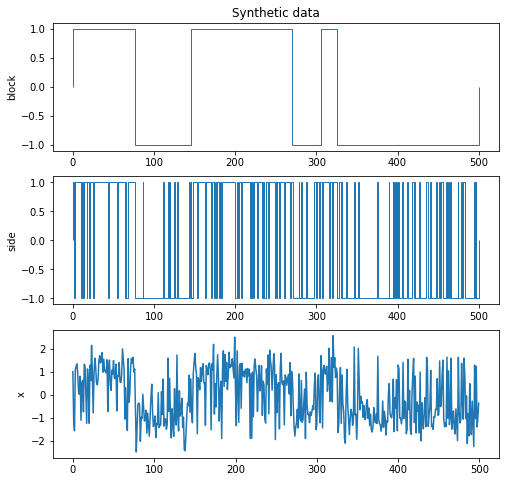

In [4]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(3, 1, figsize=(8, 8))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[0].set_title('Synthetic data');

## Run agent with optimal parameters on data

In [5]:
# Optimal values for bias and weight
w0_true = 0
w1_true = 2 / (noise_true ** 2)

# Create agent with optimal parameters
opt_agent = IBLAgent(h_true, a_true, w0_true, w1_true, rng)

# Choice samples and decision function values
y, r, q = opt_agent.sample(x, s, return_rq=True)

# Compute error from predictions
err = (s - y) ** 2
win_size = 50
err_smooth = np.convolve(err, np.ones(win_size), 'same') / win_size

# Compute average accuracy
acc = np.count_nonzero((y * s) == 1) / n_trials

### Filter results

avg. accuracy: 0.977


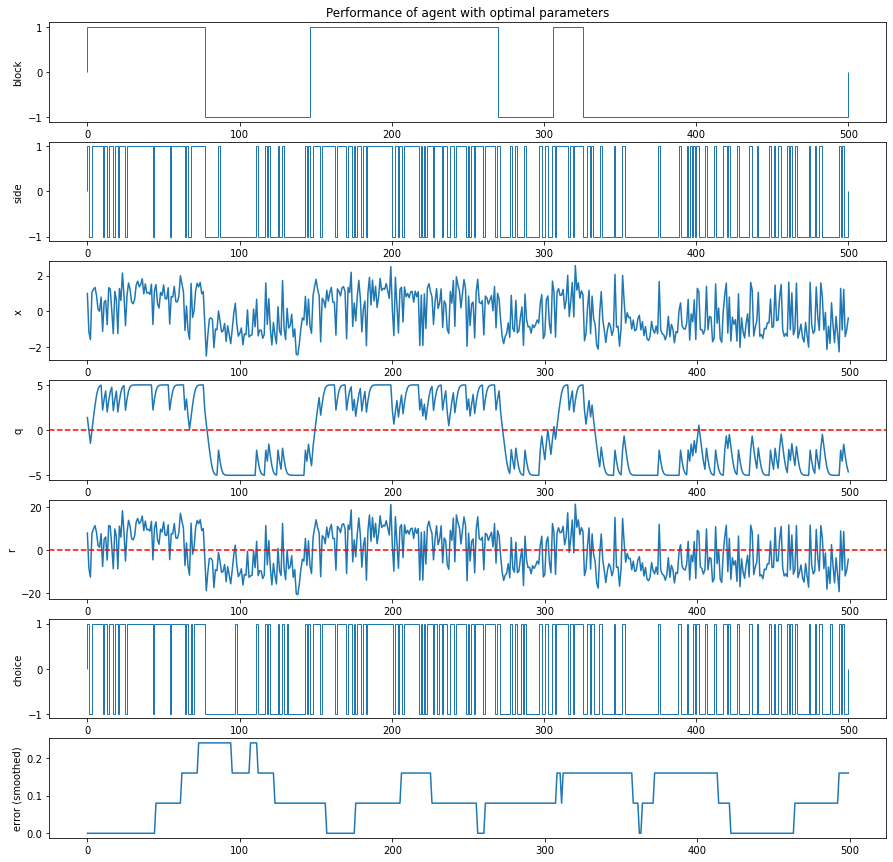

In [6]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(7, 1, figsize=(15, 15))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[3].plot(q[idx])
ax[3].axhline(y=0, color='r', linestyle='--')
ax[3].set_ylabel('q')

ax[4].plot(r[idx])
ax[4].axhline(y=0, color='r', linestyle='--')
ax[4].set_ylabel('r')

ax[5].stairs(y[idx])
ax[5].set_ylabel('choice')

ax[6].plot(err_smooth[idx])
ax[6].set_ylabel('error (smoothed)')

ax[0].set_title('Performance of agent with optimal parameters')

print(f'avg. accuracy: {acc}')

## Recover model parameters from prediction data

**Note: This is not currently working!**

In [7]:
# Fit model to preductions from optimal model
model = IBLModel()
model.fit(x, s, y)

In [8]:
# Print parameters of fit model
print(f'hazard_rate: {model.h} (opt: {h_true})')
print(f'side_probability: {model.a} (opt: {a_true})')
print(f'w_0: {model.w_0} (opt: {w0_true})')
print(f'w_1: {model.w_1} (opt: {w1_true})')

hazard_rate: 0.5 (opt: 0.02)
side_probability: 0.5 (opt: 0.8)
w_0: -0.18970968905033933 (opt: 0)
w_1: 9.416666976722057 (opt: 8.0)


In [9]:
# Choice samples and decision function values
y_model = model.predict(x, s)

# Compute average accuracy
acc_model = np.count_nonzero((y_model * y) == 1) / n_trials
print(f'model accuracy: {acc_model}')

model accuracy: 0.981


## Test optimal agent performance for varying noise values

In [10]:
def test_accuracy(n_trials=5000, a=0.8, h=0.02, noise=1.0):
    
    # Create task
    task = IBLTask(hazard_rate=h, noise=noise, alpha=a, rng=rng)
    b, s, x = task.sample_trials(n_trials)
    
    # Create agent with optimal parameters
    w0_true = 0
    w1_true = 2 / (noise ** 2)
    opt_agent = IBLAgent(h, a, w0_true, w1_true, rng)

    # Choice samples and decision function values
    y = opt_agent.sample(x, s)
    
    # Return accuracy
    return np.count_nonzero((y * s) == 1) / n_trials

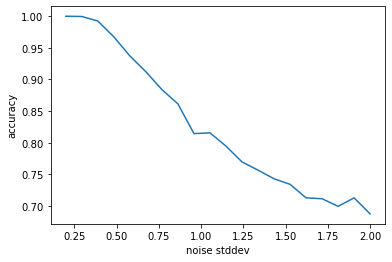

In [11]:
noise_vals = np.linspace(0.2, 2.0, 20)
acc_vals = [test_accuracy(noise=n) for n in noise_vals]

plt.plot(noise_vals, acc_vals)
plt.xlabel('noise stddev')
plt.ylabel('accuracy');

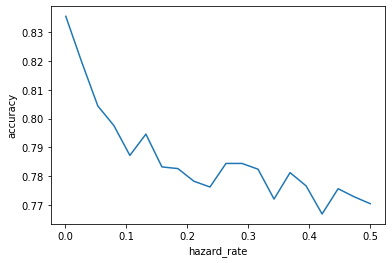

In [12]:
h_vals = np.linspace(0.001, 0.5, 20)
acc_vals = [test_accuracy(h=h) for h in h_vals]

plt.plot(h_vals, acc_vals)
plt.xlabel('hazard_rate')
plt.ylabel('accuracy');

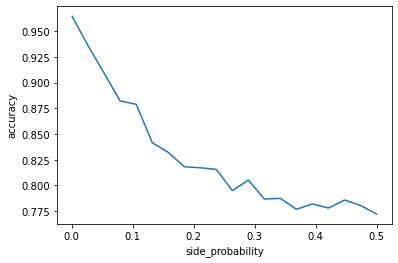

In [13]:
a_vals = np.linspace(0.001, 0.5, 20)
acc_vals = [test_accuracy(a=a) for a in a_vals]

plt.plot(a_vals, acc_vals)
plt.xlabel('side_probability')
plt.ylabel('accuracy');